In [1]:
import pandas as pd
from numba import njit
import numpy as np

import pvdeg

new temperature with irradiance function.

In [2]:
def fdm_temperature_irradiance_heat_rate(
    t_current: float, 
    t_set: float, 
    irrad_full_set: float,
    delta_time: float, 
    tau_s_temp: float, 
    heat_per_1000w: float
) -> float:

    t_next = t_current + ( t_set + heat_per_1000w / 1000 * irrad_full_set - t_current) * (1 - np.exp( -delta_time / tau_s_temp) )

    return t_next

def sample_temp_with_irradiance(
    temps_sets: np.ndarray,
    irradiances_sets: np.ndarray,
    times: np.ndarray,
    tau_s_temp: float,
    sample_temp_0: float,
    heat_per_1000w: float,
) -> np.ndarray:
    res = np.empty_like(temps_sets)
    res[0] = (
        sample_temp_0     # initial irradiance has no effect on intial temperature because it is at an instant so the accumulated irradiance (integral of G = 0)
    )

    for i in range(0, temps_sets.shape[0] - 1):
        delta_t = times[i + 1] - times[i]
        delta_t = delta_t.astype("timedelta64[m]").astype(float)

        res[i + 1] = fdm_temperature_irradiance_heat_rate(
            t_current=res[i],
            t_set=temps_sets[i + 1],
            irrad_full_set=irradiances_sets[i + 1],
            delta_time=delta_t,
            tau_s_temp=tau_s_temp, 
            heat_per_1000w=heat_per_1000w
        )

    return res

def sample_relative_humidity(chamber_temp, chamber_humidity, sample_temp):

    # we proabbly want to rewrite the psat with numba
    psat_chamber = pvdeg.humidity.psat(chamber_temp, average=False)
    psat_sample = pvdeg.humidity.psat(sample_temp, average=False)

    rh_ratio = (psat_chamber * chamber_humidity / 100) / psat_sample

    # may be better to mask and replace
    return np.minimum(rh_ratio * 100, 100)

# # @njit
# def calc_degradation_excel(
#     deg_prev,
#     time_delta,
#     sample_rh_curr,
#     sample_temp_curr,
#     irradiance_curr,
#     n,
#     p,
#     ea,
# ) -> float:
#     """latex equation shown later in notebook"""

#     # backwards difference
#     # formula above uses forwards difference
#     # mikes formula uses hours so i tried that but the rate still blows up
#     deg = deg_prev - time_delta / 60 * (sample_rh_curr ** n) * np.exp( -ea / (0.008314426 * sample_temp_curr + 273.15)) * ((irradiance_curr / 1000) ** p)
#     return deg

# def degradation_excel(
#     sample_temps: np.ndarray,
#     sample_rhs: np.ndarray,
#     irradiances_sets: np.ndarray,
#     times: np.ndarray,
# ) -> np.ndarray:
#     res = np.zeros((len(sample_temps),))

#     for i in range(1, sample_temps.shape[0] - 1):
#         delta_t = times[i] - times[i - 1]
#         delta_t = delta_t.astype("timedelta64[m]").astype(float) # why does this need to be in hours instead of minutes

#         res[i] = calc_degradation_excel(
#             deg_prev=res[i - 1],
#             time_delta=delta_t,
#             sample_temp_curr=sample_temps[i],
#             sample_rh_curr=sample_rhs[i],
#             irradiance_curr=irradiances_sets[i],
#             n=0,        # humidity dependence
#             p=0.5,      # irradiance dependence
#             ea=38.7,    # kJ/mol
#         )

#     return pd.Series(data=res, index=times)



In [3]:
mike_data = pd.read_csv(r"C:\Users\tford\Documents\mike-chamber.csv", index_col=0)
mike_data.index = pd.TimedeltaIndex(mike_data.index) + pd.Timestamp(0) # this should be added to the class

mike_setpoints = mike_data[["setpoint_temperature",	"setpoint_relative_humidity","setpoint_irradiance_full"]]
mike_setpoints = mike_setpoints.astype(float) # set to floats, we dont want people to have to do this

# mike_data

Testing if chamber temperatures and humidity make sense. These are the same as I belive they should be. Errors can likely be accounted for by floating point error and or internal representation differences.

In [4]:
tobin_air_temp = pvdeg.chamber.air_temperature(
    setpoints_df=mike_setpoints,
    tau_c_air=10,
    air_temp_0=25,
)

(tobin_air_temp - mike_data["Chamber Temperature (°C)"]).describe()

count    7.242000e+04
mean     7.595481e-11
std      1.995538e-09
min     -5.225491e-09
25%     -2.285958e-10
50%     -7.105427e-14
75%      3.369536e-10
max      5.472494e-09
dtype: float64

In [5]:
# we are going to brutalize the air_temperature function by using it to calculate chamber relative humidity 
# this is a new function that i wrote for this, adapted 1d-fdm from temperature_fdm 
tobin_chamber_rh = pvdeg.chamber.chamber_rh(
    setpoints_df=mike_setpoints,
    tau_c_rh=20,
    rh_0=50
)
    
(tobin_chamber_rh - mike_data["Chamber Humidity (%)"]).describe()

count    7.242000e+04
mean     6.905479e-13
std      1.288723e-09
min     -4.996252e-09
25%     -1.421085e-13
50%      3.552714e-14
75%      3.552714e-14
max      4.996480e-09
dtype: float64

sample tempeature issues?  
- prev, calculating with surface area and absorptance. Does not need to be this complicated. Can use temp increase per 1000W for a single point as a good approximation.

old function with the issues:  
``pvdeg.chamber._temp_calc_irradiance()``

New function expresses the logic from the excel and is much simpler. It is implemented at the top of this notebook.  Once again, numerical errors are negligable and can likely be attributed to floating point error or internal representation differences. 

In [6]:
sample_temp = sample_temp_with_irradiance(
    temps_sets=mike_setpoints['setpoint_temperature'].values,
    irradiances_sets=mike_setpoints['setpoint_irradiance_full'].values,
    times=mike_setpoints.index.values,
    tau_s_temp=10, # I think the excel sheet is using the wrong value for this, so i used the same value here but it shoiuld be the sample temperature equilibriation time
    heat_per_1000w=25, # C/1000W
    sample_temp_0=25 # C
)

tobin_sample_temp = pd.Series(data=sample_temp, index = mike_setpoints.index)

(tobin_sample_temp - mike_data["Sample Temperature (°C)"]).describe()

count    7.242000e+04
mean    -2.666197e-10
std      1.250634e-08
min     -4.992886e-08
25%     -8.691714e-10
50%     -7.105427e-14
75%      3.637746e-10
max      4.991381e-08
dtype: float64

In [7]:
tobin_sample_rh = sample_relative_humidity(
    chamber_temp=tobin_air_temp,
    chamber_humidity=tobin_chamber_rh,
    sample_temp=tobin_sample_temp
)

(tobin_sample_rh - mike_data["Sample surface humidity (%)"]).describe()

count    7.242000e+04
mean     6.801728e-10
std      1.929224e-09
min     -4.995961e-09
25%     -2.370228e-10
50%      5.202674e-10
75%      2.049838e-09
max      4.998608e-09
dtype: float64

$D_t = D_{t-1} - \left( \frac{T_{t+1} - T_{t-1}}{2} \right) \cdot RH_t^n \cdot \exp\left(\frac{-E_a}{R(T_t + 273.15)}\right) \cdot \left(\frac{I_t}{1000}\right)^p$

degradation from spreadsheet. this takes into account irradiance but is not a spectral degradation formula.  
notably uses central difference approximation instead of forward or backward difference. should all of the finite difference method implementations use central difference or some other differencing scheme.

In [ ]:
# gets us hours since start
# i really dont like the way this is working
# this function isnt working so we will use the ones below
hour_times = (mike_setpoints.index.values.astype("timedelta64[ns]") / (1e9)).astype(float)  / 3600

# tobin_deg = degradation_excel(
#     sample_temps=tobin_sample_temp.values,
#     sample_rhs=tobin_sample_rh.values,
#     irradiances_sets=mike_setpoints['setpoint_irradiance_full'].values,
#     times=hour_times # times in hours since start
# )

center differencing scheme. last timestep will be skipped. 

In [10]:
# this is a terrible way to do it
# why does it need to be in units of hours?
hour_times = (mike_setpoints.index.values.astype("timedelta64[ns]") / (1e9)).astype(float)  / 3600

n = 0
p = 0.5
ea = 38.7

irradance_sets = mike_setpoints["setpoint_irradiance_full"].values

deg = np.zeros((len(hour_times),))

for i in range(1, len(hour_times) - 1):

    deg[i] = deg[i-1] - ((hour_times[i + 1] - hour_times[i - 1]) / 2) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)

deg = pd.Series(data=deg, index=mike_setpoints.index)

C:\Users\tford\AppData\Local\Temp\1\ipykernel_7808\1155960470.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deg[i] = deg[i-1] - ((hour_times[i + 1] - hour_times[i - 1]) / 2) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)


In [11]:
# we can see that the last value is skipped, can use different differencing
deg

1970-01-01 00:00:00    0.000000e+00
1970-01-01 00:01:00   -5.670743e-09
1970-01-01 00:02:00   -1.423158e-08
1970-01-01 00:03:00   -2.642647e-08
1970-01-01 00:04:00   -4.298361e-08
                           ...     
1970-02-20 06:55:00   -8.130101e-03
1970-02-20 06:56:00   -8.130102e-03
1970-02-20 06:57:00   -8.130102e-03
1970-02-20 06:58:00   -8.130102e-03
1970-02-20 06:59:00    0.000000e+00
Length: 72420, dtype: float64

backward differencing, this shouldn't change the result because all timesteps are the same

In [12]:
n = 0
p = 0.5
ea = 38.7

irradance_sets = mike_setpoints["setpoint_irradiance_full"].values

deg = np.zeros((len(hour_times),))

for i in range(1, len(hour_times)):

    deg[i] = deg[i-1] - (hour_times[i] - hour_times[i - 1]) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)

deg = pd.Series(data=deg, index=mike_setpoints.index)

C:\Users\tford\AppData\Local\Temp\1\ipykernel_7808\2884395853.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deg[i] = deg[i-1] - (hour_times[i] - hour_times[i - 1]) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)


In [13]:
deg

1970-01-01 00:00:00    0.000000e+00
1970-01-01 00:01:00   -5.670743e-09
1970-01-01 00:02:00   -1.423158e-08
1970-01-01 00:03:00   -2.642647e-08
1970-01-01 00:04:00   -4.298361e-08
                           ...     
1970-02-20 06:55:00   -8.130101e-03
1970-02-20 06:56:00   -8.130102e-03
1970-02-20 06:57:00   -8.130102e-03
1970-02-20 06:58:00   -8.130102e-03
1970-02-20 06:59:00   -8.130103e-03
Length: 72420, dtype: float64

<Axes: >

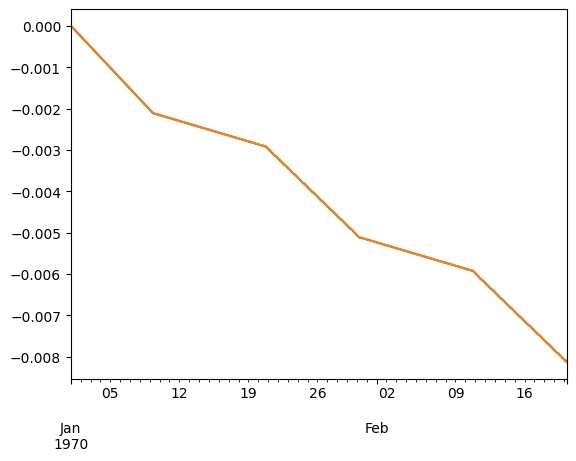

In [14]:
# they are very similar result wise
mike_data["D (%)"].plot()
deg.plot()

In [ ]:
n = 0
p = 0.5
ea = 38.7

irradance_sets = mike_setpoints["setpoint_irradiance_full"].values
ns_times = mike_setpoints.index.values

deg = np.zeros((len(hour_times),))

for i in range(1, len(hour_times)):

    # alternatively we convert to hours inside the function, why does time unit need to be in hours?
    deg[i] = deg[i-1] - ((ns_times[i] - ns_times[i - 1]).astype("float") / 1e9 / 3600) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)

deg = pd.Series(data=deg, index=mike_setpoints.index)

C:\Users\tford\AppData\Local\Temp\1\ipykernel_7808\3320530468.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deg[i] = deg[i-1] - ((ns_times[i] - ns_times[i - 1]).astype("float") / 1e9 / 3600) * (tobin_sample_rh[i] ** n) * np.exp(-ea / (0.008314426 * (273.15 + sample_temp[i]))) * ((irradance_sets[i] / 1000) ** p)


In [ ]:
# degradation rate percent per hour
deg[-1] / ((ns_times[-1] - ns_times[0]).astype("float") / 1e9 / 3600)

C:\Users\tford\AppData\Local\Temp\1\ipykernel_7808\2881138796.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  deg[-1] / ((ns_times[-1] - ns_times[0]).astype("float") / 1e9 / 3600)


-6.735886974928249e-06